<a href="https://colab.research.google.com/github/RaphaelCarvalh/BootCampAVANTI_machine_learning/blob/ativ04-et01-analise-dataset/Et01_analise_dataset_arvore_decis%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto Clothing Co-Parsing - Etapa 1 - Notebook: Análise do Dataset - TIV-04-ET-02


Carregar dataset já limpo

Distribuição de classes (Top 5):
label
image-level    1092
pixel-level    1004
Name: count, dtype: int64
Total de imagens: 2096
Features extraídas: (500, 512), Labels: 500


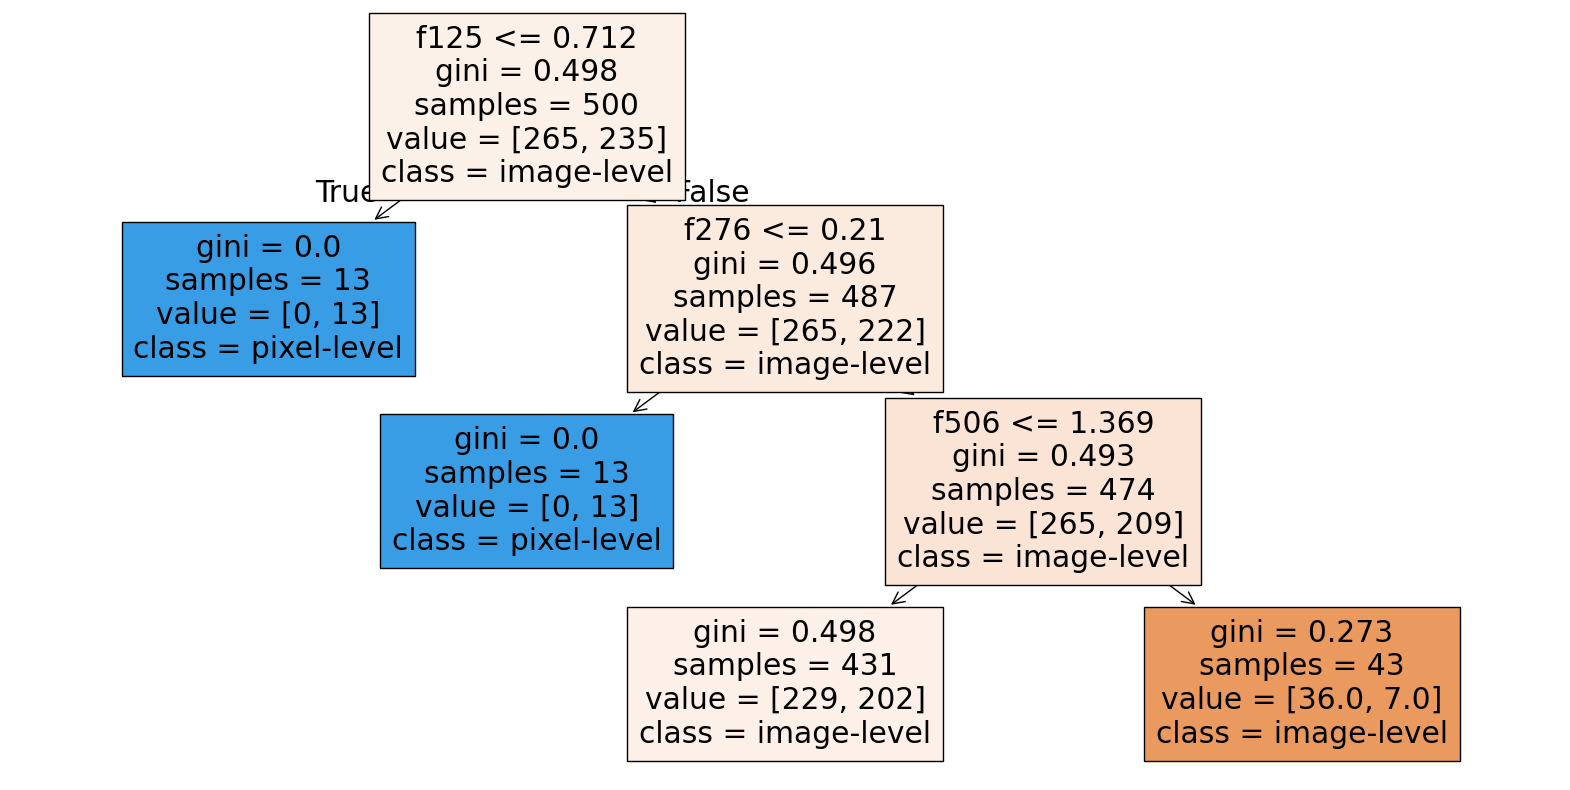

In [12]:
# ==========================================
# Notebook: Extração de Features + Árvore de Decisão
# ==========================================

import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2

from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# -------------------------------
# 1. Carregar dataset
# -------------------------------
load_path = "/content/drive/MyDrive/ClothingDataset/df_clean.csv"
df = pd.read_csv(load_path)

# Corrigir caminhos para apontar para a pasta no Drive
df['image_path'] = df['image_path'].str.replace(
    "./clothing-coparsing-dataset/images",
    "/content/drive/MyDrive/ClothingDataset/images",
    regex=False
)

# Selecionar as 5 maiores classes
top5_classes = df['label'].value_counts().nlargest(5).index
df_top5 = df[df['label'].isin(top5_classes)]

print("Distribuição de classes (Top 5):")
print(df_top5['label'].value_counts())
print(f"Total de imagens: {len(df_top5)}")

# -------------------------------
# 2. Dataset PyTorch
# -------------------------------
class ClothingDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['label']
        img = cv2.imread(img_path)

        # Garantir que a leitura funcione
        if img is None:
            raise FileNotFoundError(f"Não foi possível abrir {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

# Transformações
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Criar dataset e loader (amostra menor para estudo)
subset_df = df_top5.sample(500, random_state=42)  # reduz para acelerar
dataset = ClothingDataset(subset_df, transform)
loader = DataLoader(dataset, batch_size=16, shuffle=False)

# -------------------------------
# 3. Carregar modelo pré-treinado como extrator
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Identity()  # remove a última camada de classificação
model = model.to(device)
model.eval()

# -------------------------------
# 4. Extrair embeddings
# -------------------------------
features, labels = [], []

with torch.no_grad():
    for imgs, lbls in loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        features.append(outputs.cpu())
        labels.extend(lbls)

X = torch.cat(features).numpy()
y = labels

print(f"Features extraídas: {X.shape}, Labels: {len(y)}")

# -------------------------------
# 5. Treinar árvore de decisão
# -------------------------------
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

# -------------------------------
# 6. Plotar árvore
# -------------------------------
plt.figure(figsize=(20,10))
plot_tree(
    clf,
    filled=True,
    feature_names=[f"f{i}" for i in range(X.shape[1])],
    class_names=[str(c) for c in clf.classes_],
    max_depth=3
)
plt.show()
